# <font color='blue'> Bayesian Networks Tutorials
https://pgmpy.org/detailed_notebooks/10.%20Learning%20Bayesian%20Networks%20from%20Data.html#

In [2]:
from IPython.core.interactiveshell import InteractiveShell # 모든 명령어 출력
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

# 10. Learning Bayesian Networks from Data
- Parameter learning: Given a set of data samples and a DAG that captures the dependencies between the variables, estimate the (conditional) probability distributions of the individual variables.

- Structure learning: Given a set of data samples, estimate a DAG that captures the dependencies between the variables.

## 10.1. Parameter Learning

In [159]:
import pandas as pd
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana",
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",],
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes",
                                    "yes", "yes", "yes", "yes", "no", "no", "no"],
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
data

,fruit,tasty,size
0,banana,yes,large
1,apple,no,large
2,banana,yes,large
3,apple,yes,small
4,banana,yes,large
5,apple,yes,large
6,banana,yes,large
7,apple,yes,small
8,apple,yes,large
9,apple,yes,large


In [144]:
from pgmpy.models import BayesianModel

model = BayesianModel([('fruit', 'tasty'), ('size', 'tasty')])  # fruit -> tasty <- size

In [161]:
data['fruit'].value_counts()
data['size'].value_counts()

banana    7
apple     7
Name: fruit, dtype: int64

large    10
small     4
Name: size, dtype: int64

## 10.1.1. State counts

In [145]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)
print("\n", pe.state_counts('fruit'))  # unconditional
print("\n", pe.state_counts('tasty'))  # conditional on fruit and size


         fruit
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


In [146]:
pe.state_counts('fruit')
pe.state_counts('tasty')

,fruit
apple,7
banana,7


fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0

In [147]:
print('Tasty')
data[data['tasty'] == 'yes'].groupby(['fruit', 'size']).size().unstack().fillna(0)

print('Not Tasty')
data[data['tasty'] == 'no'].groupby(['fruit', 'size']).size().unstack()

Tasty


size,large,small
fruit,,
apple,3.0,2.0
banana,5.0,0.0


Not Tasty


size,large,small
fruit,,
apple,1,1
banana,1,1


## 10.1.2. Maximum Likelihood Estimation

- A natural estimate for the CPDs(Conditional Probability Densiti) is to simply use the relative frequencies, with which the variable states have occured. 
- We observed 7 apples among a total of 14 fruits, so we might guess that about 50% of fruits are apples.

- This approach is Maximum Likelihood Estimation (MLE). According to MLE, we should fill the CPDs. 
- This is achieved when using the relative frequencies. See [1], section 17.1 for an introduction to ML parameter estimation. pgmpy supports MLE as follows:

In [148]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('fruit'))  # unconditional
print(mle.estimate_cpd('tasty'))  # conditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+--------------------+---------------------+---------------+
| fruit      | fruit(apple) | fruit(apple)       | fruit(banana)       | fruit(banana) |
+------------+--------------+--------------------+---------------------+---------------+
| size       | size(large)  | size(small)        | size(large)         | size(small)   |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(no)  | 0.25         | 0.3333333333333333 | 0.16666666666666666 | 1.0           |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(yes) | 0.75         | 0.6666666666666666 | 0.8333333333333334  | 0.0           |
+------------+--------------+--------------------+---------------------+---------------+


In [149]:
pe.state_counts('tasty')

fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0

In [150]:
table = pe.state_counts('tasty')
table.loc['no']/table.sum(0).values
table.loc['yes']/table.sum(0).values

fruit   size 
apple   large    0.250000
        small    0.333333
banana  large    0.166667
        small    1.000000
Name: no, dtype: float64

fruit   size 
apple   large    0.750000
        small    0.666667
banana  large    0.833333
        small    0.000000
Name: yes, dtype: float64

In [151]:
# Calibrate all CPDs of `model` using MLE:
model.fit(data, estimator=MaximumLikelihoodEstimator)

## Bayesian Parameter Estimation
### A way to mitigate MLE’s overfitting is Bayesian Parameter Estimation !
- While very straightforward, the ML estimator has the problem of overfitting to the data. In above CPD, the probability of a large banana being tasty is estimated at 0.833, because 5 out of 6 observed large bananas were tasty. Fine. But note that the probability of a small banana being tasty is estimated at 0.0, because we observed only one small banana and it happened to be not tasty. But that should hardly make us certain that small bananas aren’t tasty! We simply do not have enough observations to rely on the observed frequencies. If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off.

- When estimating parameters for Bayesian networks, lack of data is a frequent problem. Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation. If a variable has 3 parents that can each take 10 states, then state counts will be done seperately for 10^3 = 1000 parents configurations. This makes MLE very fragile and unstable for learning Bayesian Network parameters. A way to mitigate MLE’s overfitting is Bayesian Parameter Estimation.

## 10.1.3. Bayesian Parameter Estimation

In [152]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, data)

print(mle.estimate_cpd('tasty'))  # conditional
print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10))

print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=100000))

print(est.estimate_cpd('tasty', prior_type='BDeu')) # default equivalent_sample_size=5

+------------+--------------+--------------------+---------------------+---------------+
| fruit      | fruit(apple) | fruit(apple)       | fruit(banana)       | fruit(banana) |
+------------+--------------+--------------------+---------------------+---------------+
| size       | size(large)  | size(small)        | size(large)         | size(small)   |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(no)  | 0.25         | 0.3333333333333333 | 0.16666666666666666 | 1.0           |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(yes) | 0.75         | 0.6666666666666666 | 0.8333333333333334  | 0.0           |
+------------+--------------+--------------------+---------------------+---------------+
+------------+---------------------+--------------------+--------------------+---------------------+
| fruit      | fruit(apple)        | fruit(apple)       | fruit(banana)      | fruit(banana)      

In [155]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator

# generate data
data = pd.DataFrame(np.random.randint(low=0, high=2, size=(5000, 4)), columns=['A', 'B', 'C', 'D'])
data

,A,B,C,D
0,0,0,1,1
1,0,1,1,1
2,1,1,0,0
3,0,1,0,1
4,0,0,0,1
...,...,...,...,...
4995,0,0,0,0
4996,1,1,0,1
4997,0,1,1,1
4998,1,1,0,0


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>]], dtype=object)

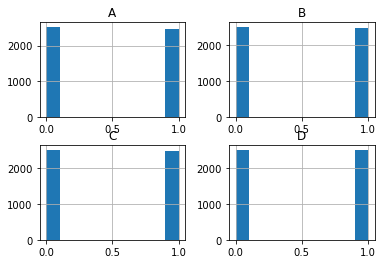

In [157]:
data.hist()

In [158]:
model = BayesianModel([('A', 'B'), ('A', 'C'), ('D', 'C'), ('B', 'D')])

model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
for cpd in model.get_cpds():
    print(cpd)

+------+----------+
| A(0) | 0.504795 |
+------+----------+
| A(1) | 0.495205 |
+------+----------+
+------+--------------------+---------------------+
| A    | A(0)               | A(1)                |
+------+--------------------+---------------------+
| B(0) | 0.5003958044725906 | 0.504841638087553   |
+------+--------------------+---------------------+
| B(1) | 0.4996041955274095 | 0.49515836191244705 |
+------+--------------------+---------------------+
+------+---------------------+--------------------+--------------------+--------------------+
| A    | A(0)                | A(0)               | A(1)               | A(1)               |
+------+---------------------+--------------------+--------------------+--------------------+
| D    | D(0)                | D(1)               | D(0)               | D(1)               |
+------+---------------------+--------------------+--------------------+--------------------+
| C(0) | 0.49517393927206915 | 0.5101305279563608 | 0.510356502688

## 10.2. Structure Learning

In [186]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel

# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y']
data

,X,Y,Z
0,2,2,4
1,1,3,4
2,2,0,2
3,2,3,5
4,2,3,5
...,...,...,...
4995,0,1,1
4996,0,1,1
4997,2,1,3
4998,2,3,5


In [187]:
def summary(df) :
    tf = pd.DataFrame({'데이터형태(dtypes)' : df.dtypes,
                       '결측치 수(null)' : df.isnull().sum(),
                       '결측치 비율(%)' : (df.isnull().sum()/len(df)).round(2),
                       '고유값 수(nunique)' : df.nunique(),
                      })
    for col in tf.index:
        tf.loc[col, '자료 내용(contents)'] = str(df[col].unique()[0:5])
        
    return tf

In [188]:
summary(data)

,데이터형태(dtypes),결측치 수(null),결측치 비율(%),고유값 수(nunique),자료 내용(contents)
X,int32,0,0.0,4,[2 1 0 3]
Y,int32,0,0.0,4,[2 3 0 1]
Z,int32,0,0.0,7,[4 2 5 1 3]


## 모댈의 변수 관련성을 Search
- 원래모델의 score가 적다 X -> Z <- Y

In [189]:
bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)

model1 = BayesianModel([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y
model2 = BayesianModel([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z


print(bdeu.score(model1))
print(k2.score(model1))
print(bic.score(model1))

-13935.348138559864
-14326.04990159809
-14291.3904132051


In [190]:
print(bdeu.score(model2))
print(k2.score(model2))
print(bic.score(model2))

-20892.17175111015
-20919.027052236866
-20936.22611938911


- While the scores vary slightly, we can see that the correct model1 has a much higher score than model2. 
- Importantly, these scores decompose, i.e. they can be computed locally for each of the variables given their potential parents, independent of other parts of the network:

In [191]:
print(bdeu.local_score('Z', parents=[]))
print(bdeu.local_score('Z', parents=['X']))
print(bdeu.local_score('Z', parents=['X', 'Y']))

bdeu.local_score('Z', parents=[]) + bdeu.local_score('Z', parents=['X']) + bdeu.local_score('Z', parents=['X', 'Y'])

-9284.560153420645
-6987.169396818714
-57.115082353636524


-16328.844632592996

## 10.2.2. Search strategies

In [192]:
data.head()

,X,Y,Z
0,2,2,4
1,1,3,4
2,2,0,2
3,2,3,5
4,2,3,5


In [193]:
from pgmpy.estimators import ExhaustiveSearch

es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())

[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-14291.3904132051 [('X', 'Z'), ('Y', 'Z')]
-14322.265045660472 [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
-14322.265045660472 [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-14322.265045660472 [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-14322.265045660472 [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-14322.265045660472 [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-14322.265045660472 [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
-16587.006525317352 [('Y', 'X'), ('Z', 'X')]
-16587.95455470898 [('X', 'Y'), ('Z', 'Y')]
-18640.610007276853 [('Z', 'X'), ('Z', 'Y')]
-18640.610007276853 [('Y', 'Z'), ('Z', 'X')]
-18640.610007276853 [('X', 'Z'), ('Z', 'Y')]
-20905.351486933738 [('Z', 'X')]
-20905.351486933738 [('X', 'Z')]
-20906.299516325365 [('Z', 'Y')]
-20906.299516325365 [('Y', 'Z')]
-20936.226119389106 [('X', 'Y'), ('X', 'Z')]
-20936.22611938911 [('X', 'Z'), ('Y', 'X')]
-20936.22611938911 [('X', 'Y'), ('Z', 'X')]
-20937.174148780738 [('Y', 'X'), ('Z', 'Y')]
-20937.174148780738 [('Y', 'Z'), ('Y

In [195]:
from pgmpy.estimators import HillClimbSearch

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Y', 'X'), ('Y', 'Z'), ('Z', 'X')]


In [196]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('A', 'H'), ('B', 'A'), ('C', 'A'), ('G', 'H')]


In [172]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('A', 'H'), ('B', 'A'), ('C', 'A'), ('G', 'H')]


## 10.2.3. (Conditional) Independence Tests

In [197]:
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

print(chi_square(X='B', Y='H', Z=[], data=data, significance_level=0.05))          # dependent
print(chi_square(X='B', Y='E', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='B', Y='H', Z=['A'], data=data, significance_level=0.05))       # independent
print(chi_square(X='A', Y='G', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='A', Y='G', Z=['H'], data=data, significance_level=0.05))       # dependent

False
True
True
True
False


## 10.2.4. DAG (pattern) construction

In [198]:
est = PC(data)
skel, seperating_sets = est.build_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = pdag.to_dag()
print("DAG edges:        ", model.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Undirected edges:  [('A', 'B'), ('A', 'C'), ('A', 'H'), ('E', 'F'), ('G', 'H')]
PDAG edges:        [('C', 'A'), ('A', 'H'), ('B', 'A'), ('G', 'H'), ('E', 'F'), ('F', 'E')]
DAG edges:         [('C', 'A'), ('A', 'H'), ('B', 'A'), ('G', 'H'), ('E', 'F')]


In [199]:
print(est.estimate(significance_level=0.01).edges())

  0%|          | 0/5 [00:00<?, ?it/s]

[('C', 'A'), ('A', 'H'), ('B', 'A'), ('G', 'H'), ('E', 'F')]


## 10.2.4.1. Hybrid Structure Learning

In [200]:
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

mmhc = MmhcEstimator(data)
skeleton = mmhc.mmpc()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data)
model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges(), scoring_method=BDeuScore(data))
print("Part 2) Model:    ", model.edges())

Part 1) Skeleton:  [('A', 'H'), ('A', 'C'), ('A', 'B'), ('A', 'F'), ('B', 'G'), ('C', 'E'), ('D', 'H'), ('D', 'G'), ('E', 'F'), ('E', 'G'), ('F', 'G'), ('G', 'H')]


  0%|          | 0/1000000 [00:00<?, ?it/s]

Part 2) Model:     [('A', 'C'), ('A', 'B'), ('B', 'G'), ('F', 'E'), ('H', 'A'), ('H', 'G')]


# End

In [86]:
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana",
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",]*10000,
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes",
                                    "yes", "yes", "yes", "yes", "no", "no", "no"]*10000,
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]*10000})
data

,fruit,tasty,size
0,banana,yes,large
1,apple,no,large
2,banana,yes,large
3,apple,yes,small
4,banana,yes,large
...,...,...,...
139995,apple,yes,large
139996,banana,yes,large
139997,banana,no,large
139998,apple,no,small


In [87]:
data.loc[data['tasty'] == 'yes', 'tasty'] = 1
data.loc[data['tasty'] == 'no','tasty'] = 0

In [88]:
data.groupby(['fruit', 'size'])['tasty'].sum().unstack()

size,large,small
fruit,,
apple,30000,20000
banana,50000,0


In [90]:
data.groupby(['fruit', 'size']).sum().unstack().reset_index()

fruit  tasty       
size          large  small
0      apple  30000  20000
1     banana  50000      0